# Team Members

- Lookkaew Pongtiyapaiboon
- Muhammad Murtadha R
- Cathy Tong
- Catherine Huang
- Kaicheng (Cathy) Zhang

# Import

# Load Datasets

In [1]:
stocks = pd.read_feather('crsp_monthly_stocks.feather')
cstat  = pd.read_feather('compustat_annual.feather')

NameError: name 'pd' is not defined

# Stock Selection

[*********************100%%**********************]  5 of 5 completed
Optimal Weights:
NVDA: 0.3017
META: 0.6983
AMZN: 0.0000
TSLA: 0.0000
GOOG: 0.0000

Portfolio Performance:
Expected Portfolio Return: 11.27%
Portfolio Risk (Standard Deviation): 33.19%


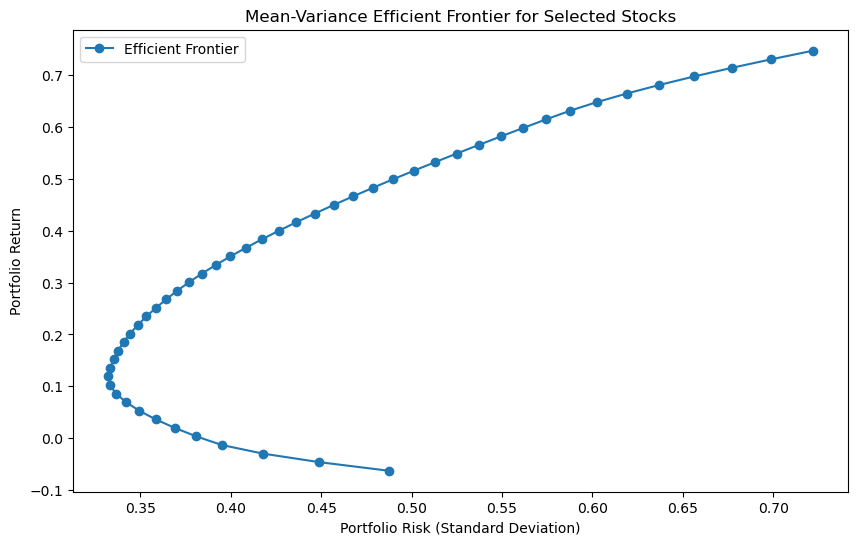

In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Step 1: Pull sample data for selected stocks
tickers = ['NVDA', 'META', 'AMZN', 'TSLA', 'GOOG']
data = yf.download(tickers, start='2020-01-01', end='2023-01-01')['Adj Close']

# Step 2: Calculate daily returns
returns = data.pct_change().dropna()

# Step 3: Calculate expected returns and covariance matrix
expected_returns = returns.mean() * 252  # Annualize returns
cov_matrix = returns.cov() * 252         # Annualize covariance matrix

# Number of assets
num_assets = len(expected_returns)

# Step 4: Define the optimization problem

# Initial guess for weights
init_guess = np.array([1.0 / num_assets] * num_assets)

# Constraints: Weights sum to 1
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

# Bounds for weights (0 to 1 for no short selling)
bounds = tuple((0, 1) for _ in range(num_assets))

# Objective function: Portfolio variance
def portfolio_variance(weights, cov_matrix):
    return weights.T @ cov_matrix @ weights

# Solve for weights that minimize portfolio variance
result = minimize(portfolio_variance, init_guess, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)

# Optimized portfolio weights
optimal_weights = result.x

# Step 5: Calculate portfolio risk and return
portfolio_return = np.dot(optimal_weights, expected_returns)
portfolio_risk = np.sqrt(portfolio_variance(optimal_weights, cov_matrix))

# Display results
print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

print("\nPortfolio Performance:")
print(f"Expected Portfolio Return: {portfolio_return:.2%}")
print(f"Portfolio Risk (Standard Deviation): {portfolio_risk:.2%}")

# Step 6: Plot Efficient Frontier

# Efficient frontier calculation
target_returns = np.linspace(expected_returns.min(), expected_returns.max(), 50)
risks = []

for r in target_returns:
    # Add a return constraint
    constraints = (
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # Weights sum to 1
        {'type': 'eq', 'fun': lambda w: np.dot(w, expected_returns) - r}  # Target return
    )
    result = minimize(portfolio_variance, init_guess, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)
    risks.append(np.sqrt(portfolio_variance(result.x, cov_matrix)))

# Plot efficient frontier
plt.figure(figsize=(10, 6))
plt.plot(risks, target_returns, 'o-', label='Efficient Frontier')
plt.xlabel('Portfolio Risk (Standard Deviation)')
plt.ylabel('Portfolio Return')
plt.title('Mean-Variance Efficient Frontier for Selected Stocks')
plt.legend()
plt.show()

Annualized Return: 5.93%
Annualized Volatility: 33.19%
Sharpe Ratio: 0.12


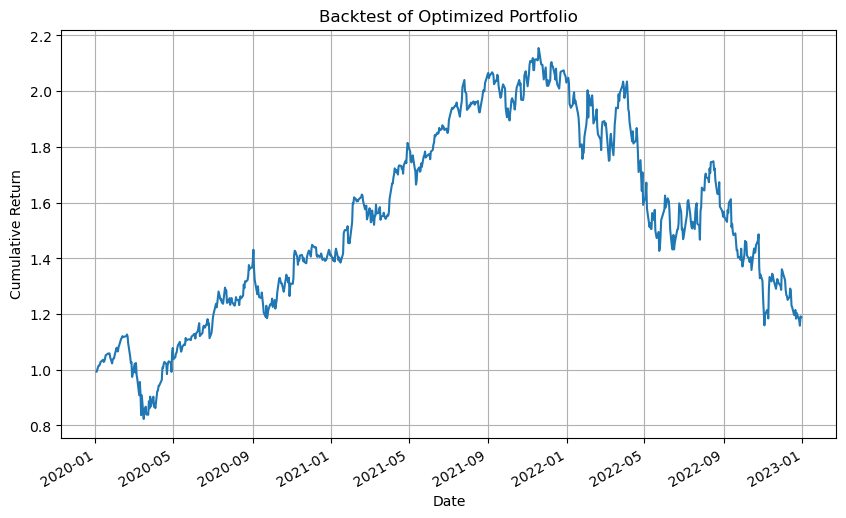

In [7]:
# Assuming 'returns' is the historical daily returns DataFrame and 'optimal_weights' is the optimized weights array.

# Step 1: Calculate portfolio returns
portfolio_returns = (returns * optimal_weights).sum(axis=1)

# Step 2: Calculate cumulative returns
cumulative_returns = (1 + portfolio_returns).cumprod()

# Step 3: Calculate performance metrics
# Annualized return
total_period = len(portfolio_returns) / 252  # Assuming 252 trading days per year
annualized_return = cumulative_returns.iloc[-1]**(1/total_period) - 1

# Annualized volatility
annualized_volatility = portfolio_returns.std() * np.sqrt(252)

# Risk-free rate (assume 2% for example)
risk_free_rate = 0.02
sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

# Display results
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Step 4: Plot cumulative returns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
cumulative_returns.plot(title='Backtest of Optimized Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid()
plt.show()


[*********************100%%**********************]  5 of 5 completed
Performance Metrics:
Annualized Return: 1.42%
Annualized Volatility: 1.04%
Sharpe Ratio: -0.55


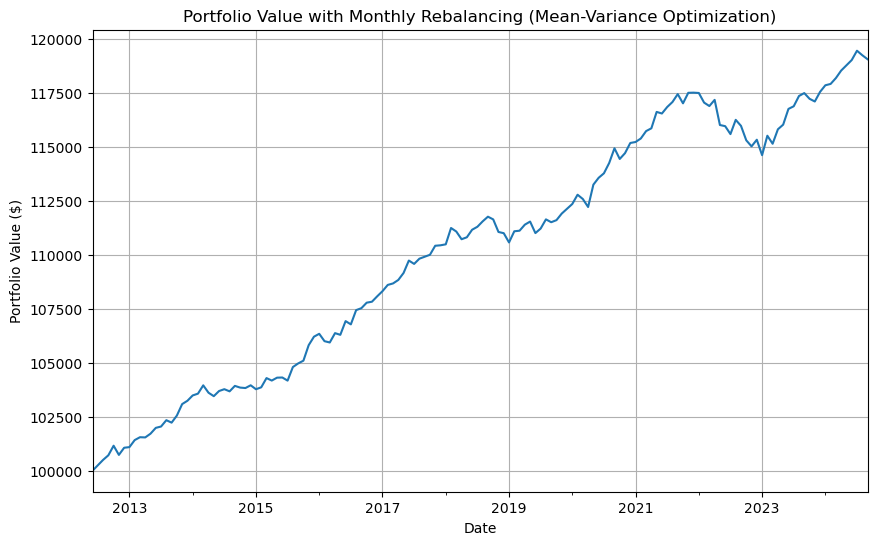


Weights History (First 5 Rows):
                NVDA      META      AMZN      TSLA      GOOG
Date                                                        
2012-07-31  0.000000  0.361354  0.203254  0.209561  0.225832
2012-08-31  0.314929  0.637432  0.031937  0.000000  0.015702
2012-09-30  0.087219  0.715627  0.108161  0.031849  0.057143
2012-10-31  0.176912  0.648461  0.089141  0.061190  0.024296
2012-11-30  0.185995  0.662402  0.078594  0.061923  0.011085


In [33]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Step 1: Download stock data
tickers = ['NVDA', 'META', 'AMZN', 'TSLA', 'GOOG']
data = yf.download(tickers, start='2000-01-01', end='2024-10-01')['Adj Close']

# Step 2: Calculate daily returns and resample to monthly
returns = data.pct_change().dropna()
monthly_returns = returns.resample('M').mean()  # Average returns for each month

# Step 3: Define mean-variance optimization function
def calculate_optimal_weights(cov_matrix, expected_returns):
    num_assets = len(expected_returns)
    init_guess = np.array([1.0 / num_assets] * num_assets)
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})  # Weights sum to 1
    bounds = tuple((0, 1) for _ in range(num_assets))  # No short-selling

    # Objective: Minimize portfolio variance
    def portfolio_variance(weights, cov_matrix):
        return weights.T @ cov_matrix @ weights

    result = minimize(portfolio_variance, init_guess, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Step 4: Backtest with monthly rebalancing
portfolio_values = [100000]  # Start with an initial portfolio value
weights_history = []
optimal_weights = None
dates = monthly_returns.index

for i in range(1, len(dates)-1):
    # Use data up to the current month to calculate expected returns and covariance matrix
    past_data = returns.loc[:dates[i-1]]
    expected_returns = past_data.mean() * 252  # Annualized returns
    cov_matrix = past_data.cov() * 252         # Annualized covariance matrix

    # Calculate optimal weights for the month
    optimal_weights = calculate_optimal_weights(cov_matrix, expected_returns)
    weights_history.append(optimal_weights)

    # Calculate portfolio return for the month
    monthly_portfolio_return = np.dot(optimal_weights, monthly_returns.loc[dates[i]])
    new_portfolio_value = portfolio_values[-1] * (1 + monthly_portfolio_return)
    portfolio_values.append(new_portfolio_value)

# Convert portfolio values to a Series for plotting
# portfolio_values = pd.Series(portfolio_values,)
# weights_history = pd.DataFrame(weights_history, columns=tickers)


portfolio_values = pd.Series(portfolio_values, index=dates[1:])
weights_history = pd.DataFrame(weights_history, index=dates[2:], columns=tickers)

# Step 5: Evaluate performance metrics
cumulative_return = portfolio_values.iloc[-1] / portfolio_values.iloc[0] - 1
annualized_return = (1 + cumulative_return)**(12 / len(portfolio_values)) - 1
annualized_volatility = portfolio_values.pct_change().std() * np.sqrt(12)
sharpe_ratio = (annualized_return - 0.02) / annualized_volatility  # Assuming 2% risk-free rate

# Print performance metrics
print("Performance Metrics:")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Step 6: Plot portfolio growth
plt.figure(figsize=(10, 6))
portfolio_values.plot(title='Portfolio Value with Monthly Rebalancing (Mean-Variance Optimization)', ylabel='Portfolio Value ($)', xlabel='Date', grid=True)
plt.show()

# Step 7: Show weights history
print("\nWeights History (First 5 Rows):")
print(weights_history.head())



In [23]:
portfolio_values.info()

<class 'pandas.core.series.Series'>
RangeIndex: 148 entries, 0 to 147
Series name: None
Non-Null Count  Dtype  
--------------  -----  
148 non-null    float64
dtypes: float64(1)
memory usage: 1.3 KB


In [31]:
len(dates[1:])

148

In [18]:
portfolio_values.head()

0    100000.000000
1    100249.719409
2    100500.601590
3    100714.254480
4    101158.166424
dtype: float64

In [37]:
weights_history['total'] = weights_history.sum(axis = 1)
weights_history.head()

,NVDA,META,AMZN,TSLA,GOOG,total
Date,,,,,,
2012-07-31,0.000000,0.361354,0.203254,0.209561,0.225832,1.0
2012-08-31,0.314929,0.637432,0.031937,0.000000,0.015702,1.0
2012-09-30,0.087219,0.715627,0.108161,0.031849,0.057143,1.0
2012-10-31,0.176912,0.648461,0.089141,0.061190,0.024296,1.0
2012-11-30,0.185995,0.662402,0.078594,0.061923,0.011085,1.0
